In [1]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of the desired size
    Maps the pixel values in masks to represent only three classes: background, bubble, outline
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h, i_w, i_c = target_shape_img   # pull height, width, and channels of image
    m_h, m_w, m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as the number of images along with the shape of one image
    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)
    
    # Resize images and map pixel values in masks
    for file in img:
        # convert image into an array of the desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h, i_w))
        single_img = np.reshape(single_img, (i_h, i_w, i_c)) 
        single_img = single_img / 256.
        X[index] = single_img
        
        # convert mask into an array of the desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        
        # Map pixel values to represent only three classes: background, bubble, outline
        single_mask = np.asarray(single_mask).copy()
        single_mask[single_mask == 0] = 0  # Background
        single_mask[(single_mask > 0) & (single_mask < 255)] = 1  # Bubble
        single_mask[single_mask == 255] = 2  # Outline
        
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c)) 
        y[index] = single_mask
    
    return X, y


In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = 'C:/Users/rupes/Downloads/Research_Unet_Boiling/data/images/'
path2 = 'C:/Users/rupes/Downloads/Research_Unet_Boiling/data/masks/'
img, mask = LoadData (path1, path2)
# View an example of image and corresponding mask 
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (114, 128, 128, 3)
Y shape: (114, 128, 128, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

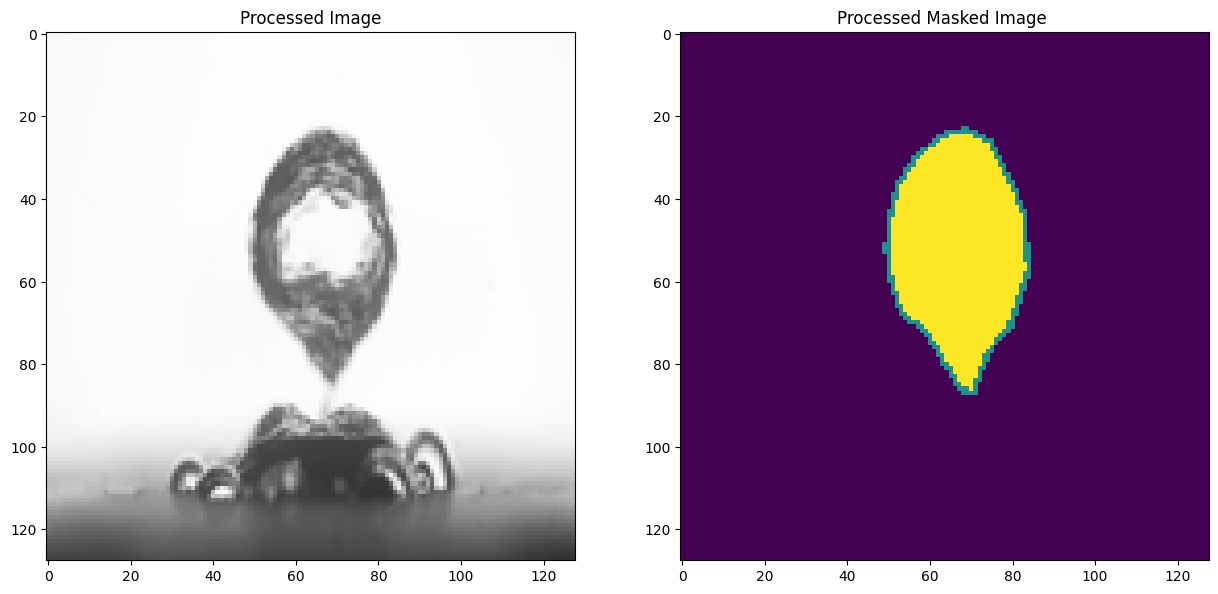

In [25]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, buble, outline
print(np.unique(y))

# Visualize the output
image_index = 77
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

In [26]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [28]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 128, 128, 32)         896       ['input_3[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_40[0][0]']           
                                                                                                  
 batch_normalization_10 (Ba  (None, 128, 128, 32)         128       ['conv2d_41[0][0]']           
 tchNormalization)                                                                          

 e)                                                                  'batch_normalization_11[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 64, 64, 64)           73792     ['concatenate_10[0][0]']      
                                                                                                  
 conv2d_55 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_54[0][0]']           
                                                                                                  
 conv2d_transpose_11 (Conv2  (None, 128, 128, 32)         18464     ['conv2d_55[0][0]']           
 DTranspose)                                                                                      
                                                                                                  
 concatena

In [29]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
5/5 [==============================] - 67s 12s/step - loss: 1.2161 - accuracy: 0.6450 - val_loss: 0.4317 - val_accuracy: 0.9160
Epoch 2/30
5/5 [==============================] - 62s 13s/step - loss: 0.3877 - accuracy: 0.9162 - val_loss: 0.3357 - val_accuracy: 0.9160
Epoch 3/30
5/5 [==============================] - 59s 12s/step - loss: 0.4177 - accuracy: 0.9162 - val_loss: 0.3276 - val_accuracy: 0.9160
Epoch 4/30
5/5 [==============================] - 59s 12s/step - loss: 0.3231 - accuracy: 0.9162 - val_loss: 0.3193 - val_accuracy: 0.9160
Epoch 5/30
5/5 [==============================] - 56s 12s/step - loss: 0.3097 - accuracy: 0.9162 - val_loss: 0.3093 - val_accuracy: 0.9160
Epoch 6/30
5/5 [==============================] - 60s 12s/step - loss: 0.2927 - accuracy: 0.9162 - val_loss: 0.2574 - val_accuracy: 0.9160
Epoch 7/30
5/5 [==============================] - 57s 11s/step - loss: 0.2667 - accuracy: 0.9162 - val_loss: 0.2220 - val_accuracy: 0.9160
Epoch 8/30
5/5 [===========

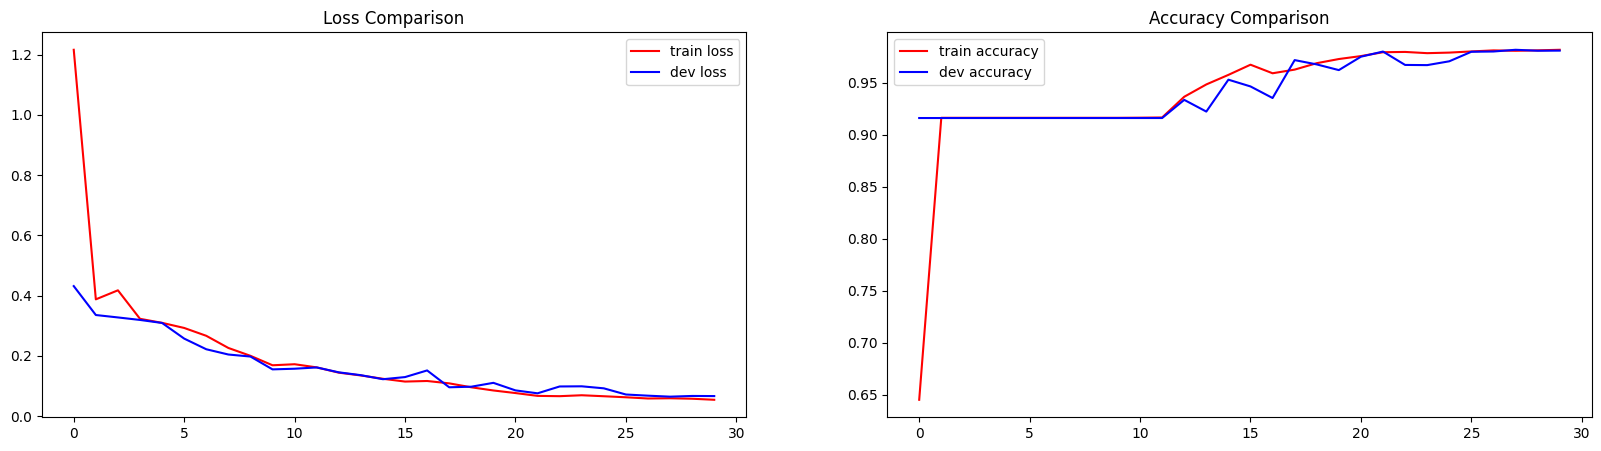

In [31]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [32]:
unet.evaluate(X_valid, y_valid)

2/2 [==============================] - 6s 557ms/step - loss: 0.0666 - accuracy: 0.9808


[0.06659671664237976, 0.9808332324028015]

In [33]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 1s 1s/step


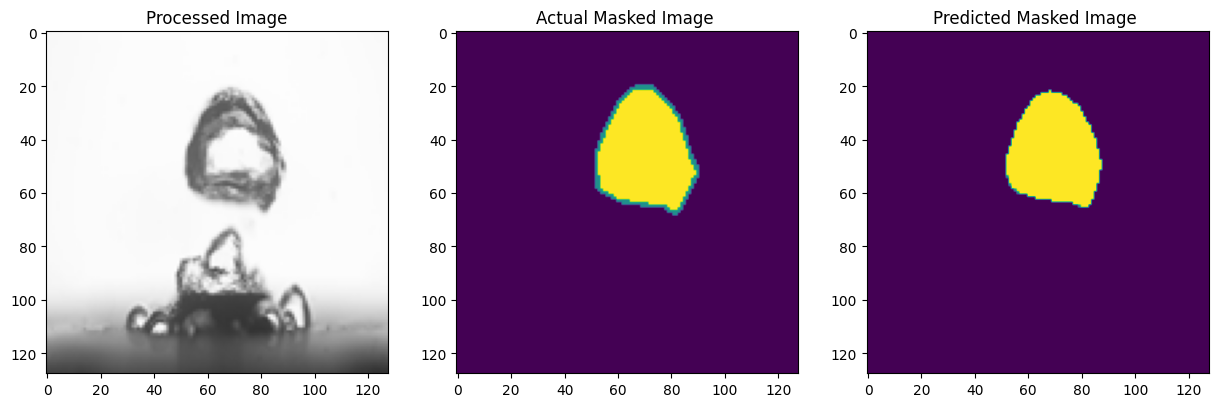

In [34]:
# Add any index to contrast the predicted mask with actual mask
index = 1
VisualizeResults(index)

# IOU


### Average IOU

In [35]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_average_iou(model, X_data, y_data):
    total_iou = 0.0
    num_examples = len(X_data)

    for index in range(num_examples):
        img = X_data[index]
        img = img[np.newaxis, ...]  # Add batch dimension for model prediction
        actual_mask = y_data[index, :, :, 0]

        # Get model prediction
        pred_y = model.predict(img)
        pred_mask = tf.argmax(pred_y[0], axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]

        # Calculate IoU
        iou = calculate_iou(actual_mask, pred_mask[:, :, 0])
        total_iou += iou

    average_iou = total_iou / num_examples
    return average_iou

# Usage:
average_iou = calculate_average_iou(unet, X_valid, y_valid)
print(f'Average IoU: {average_iou}')


1/1 [==============================] - 0s 296ms/step
Average IoU: 0.8287904895895237


1/1 [==============================] - 0s 277ms/step


C:\Users\rupes\AppData\Local\Temp\ipykernel_24028\3824996887.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, arr = plt.subplots(1, 3, figsize=(15, 15))


1/1 [==============================] - 0s 184ms/step


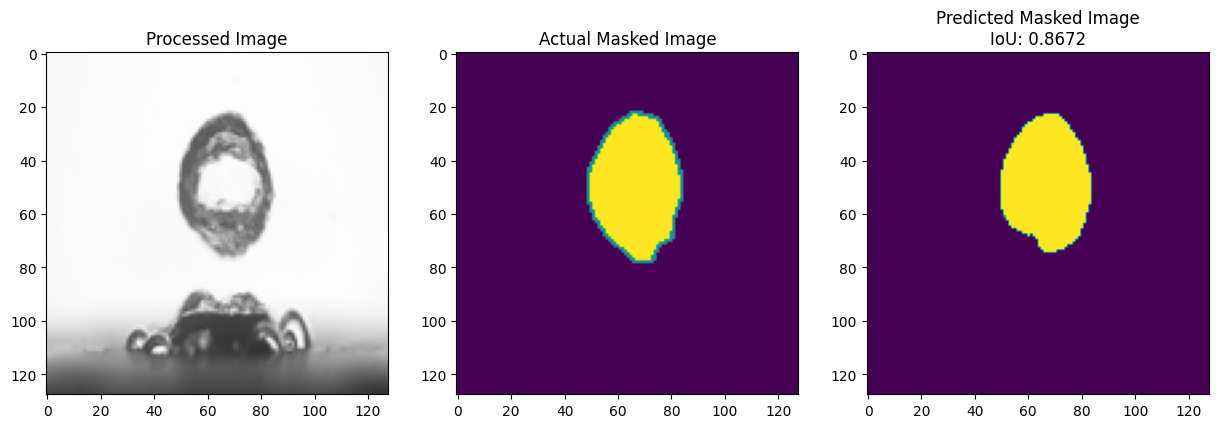

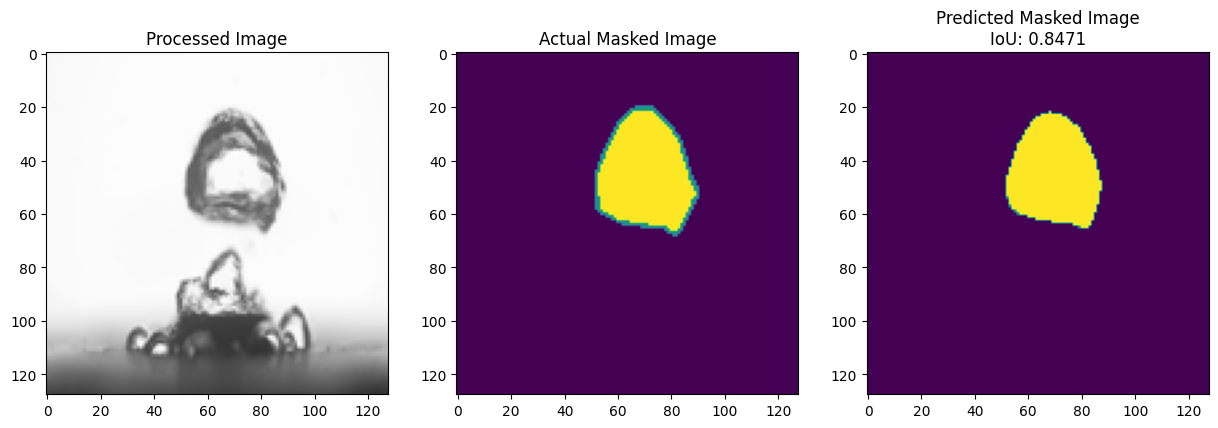

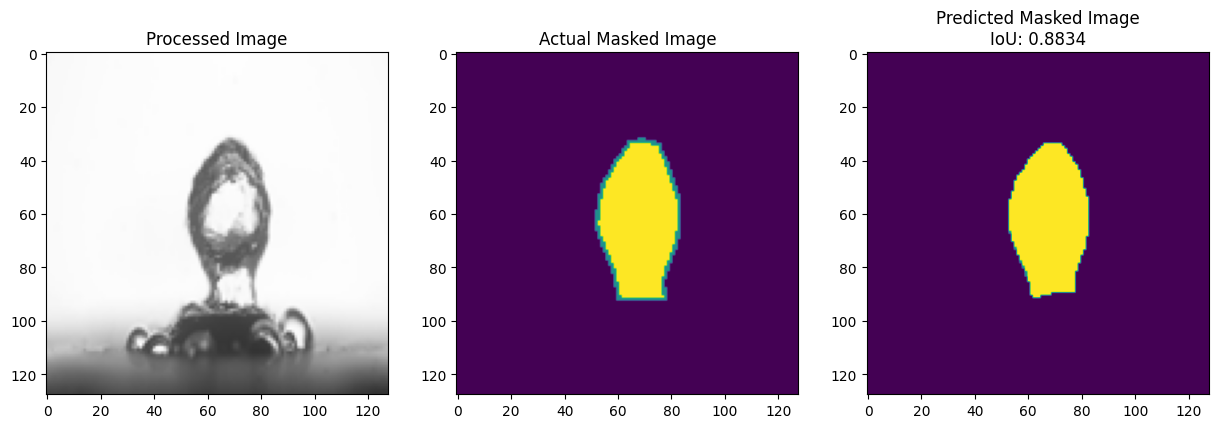

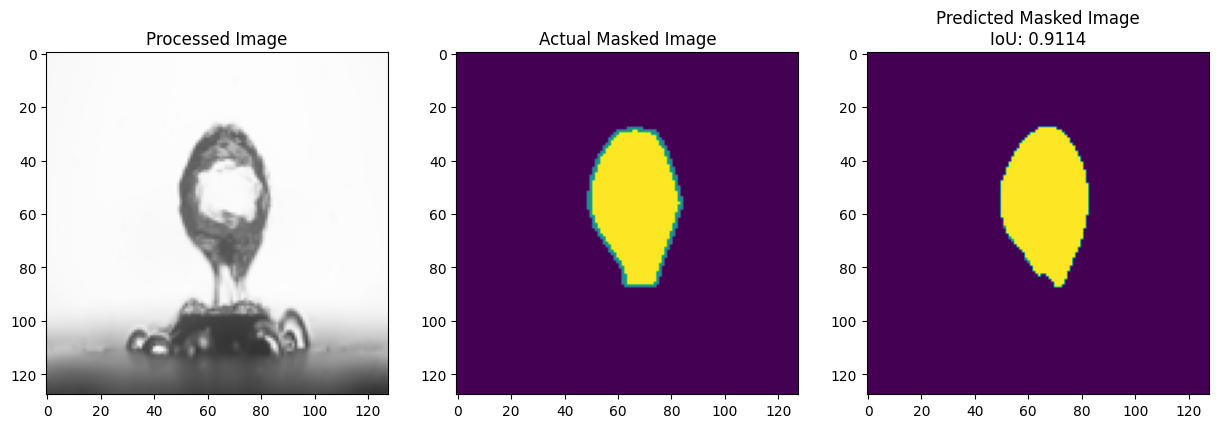

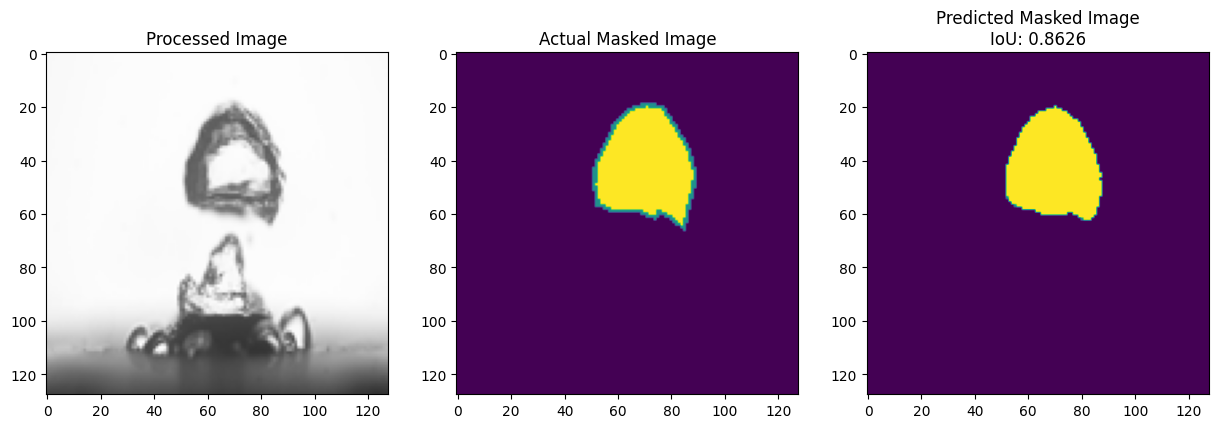

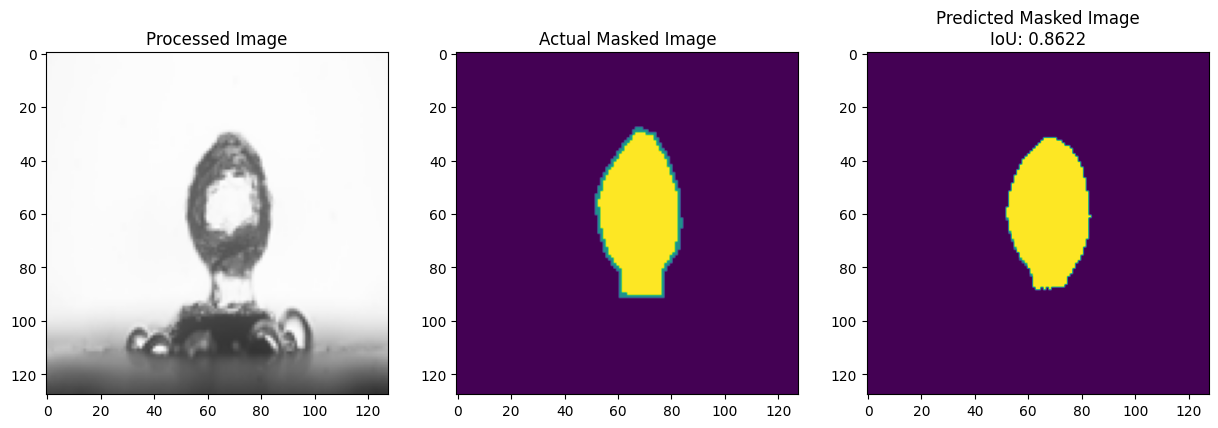

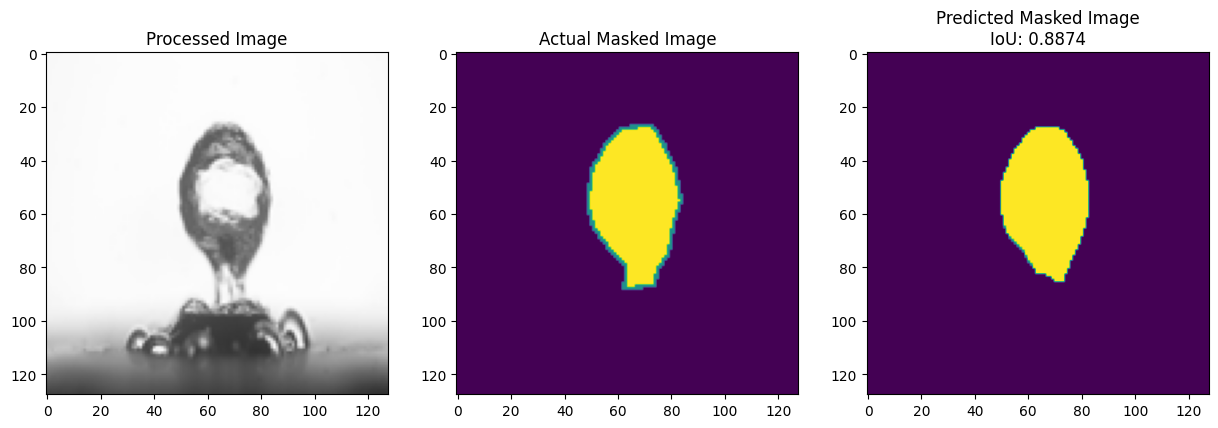

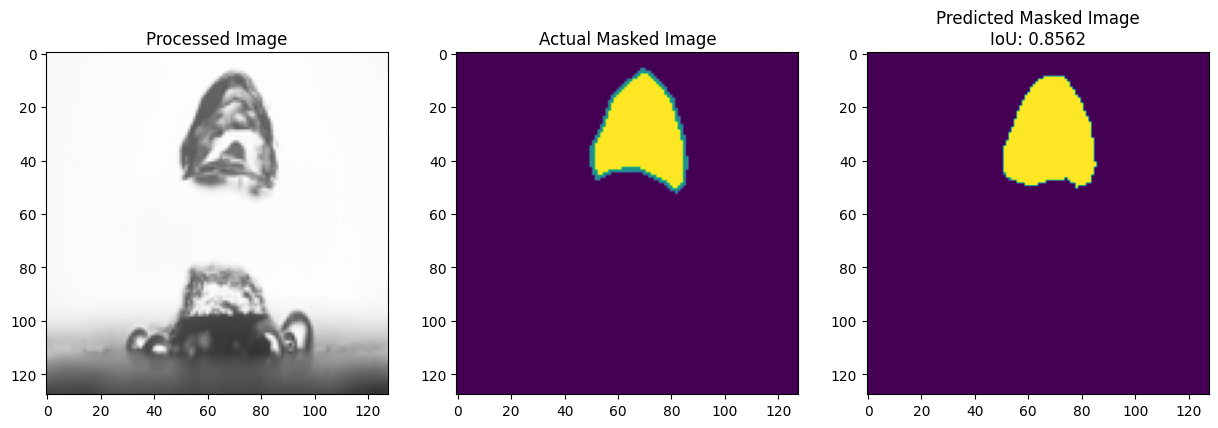

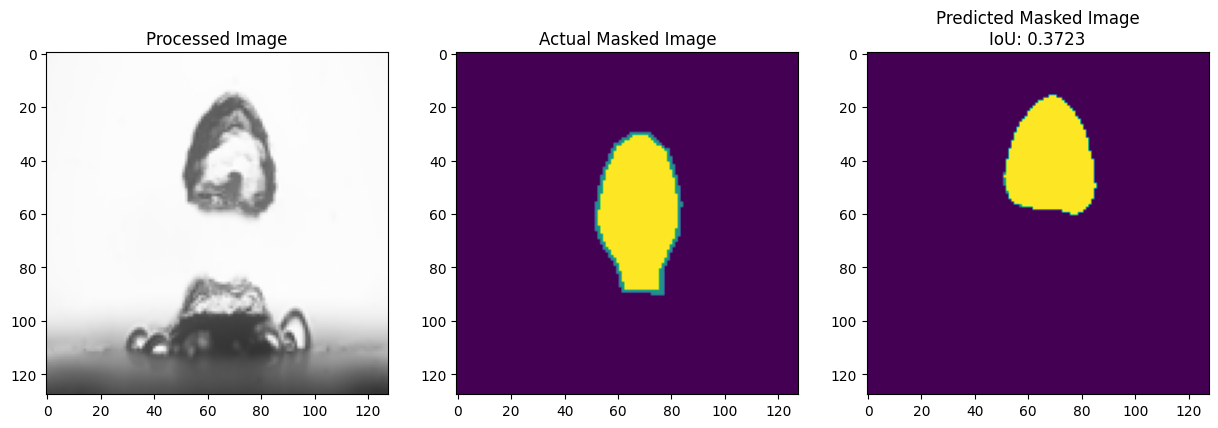

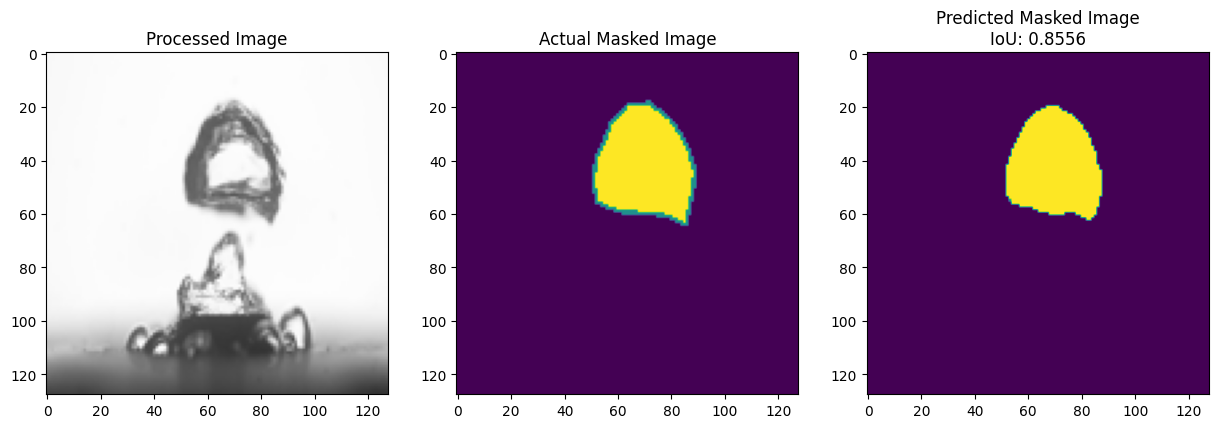

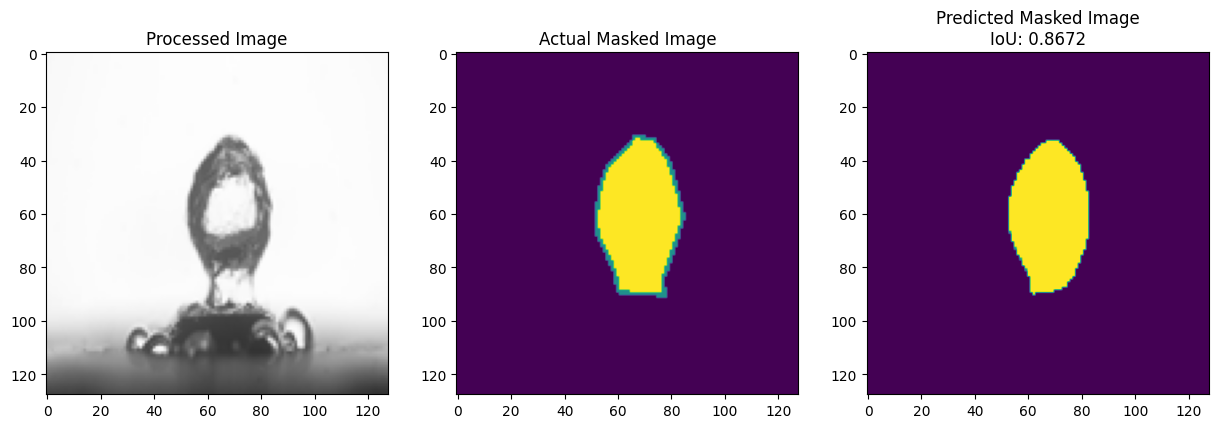

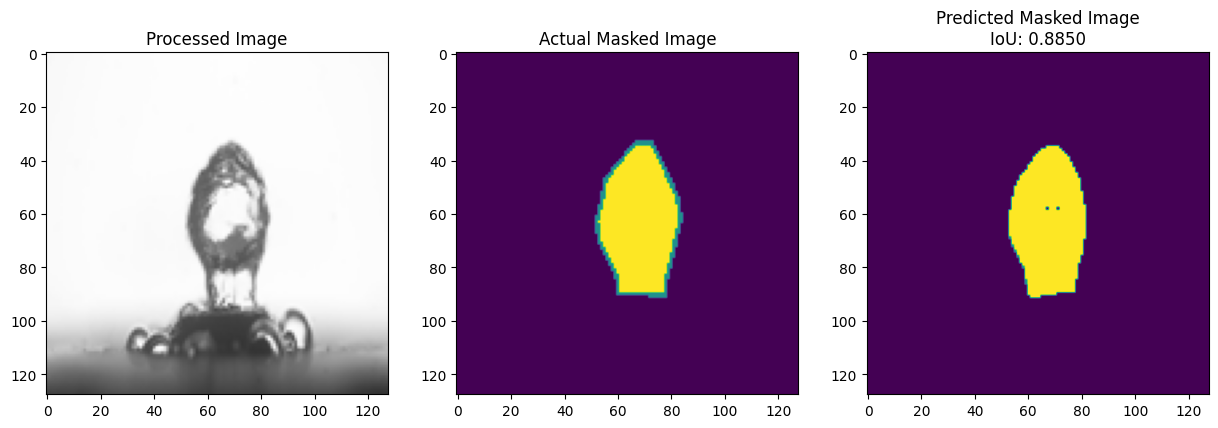

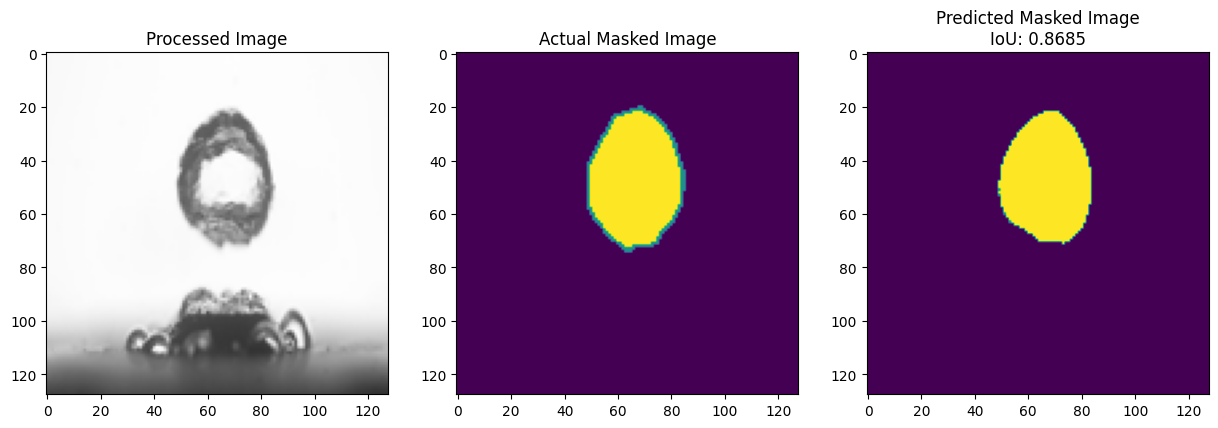

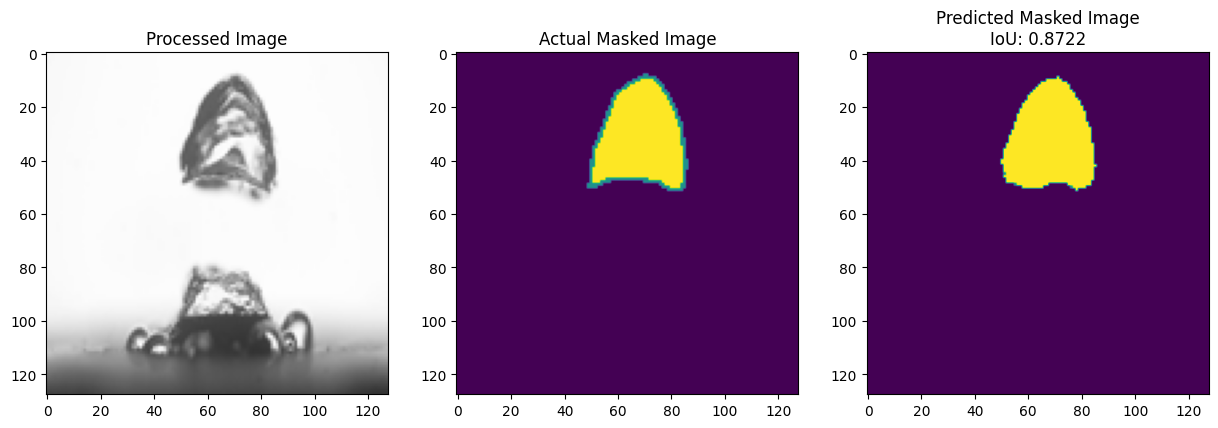

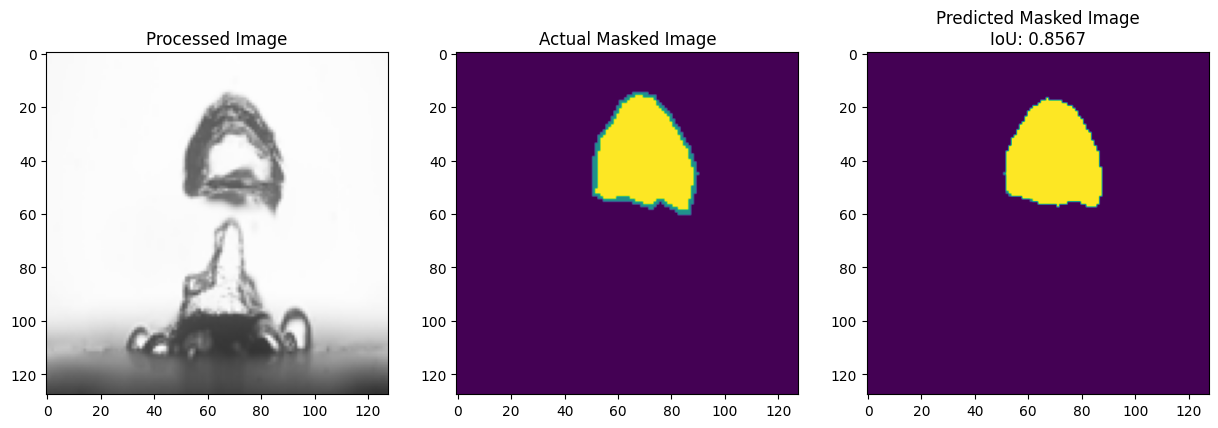

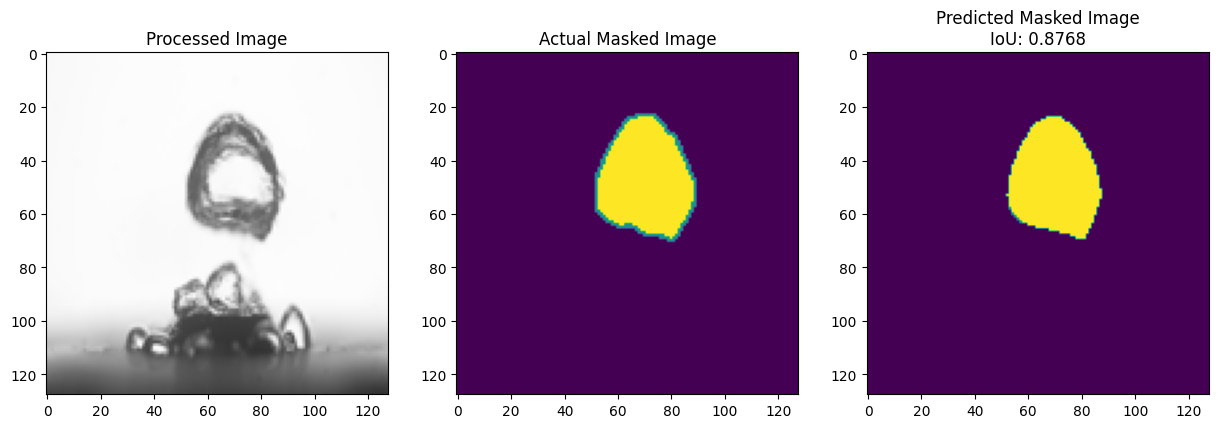

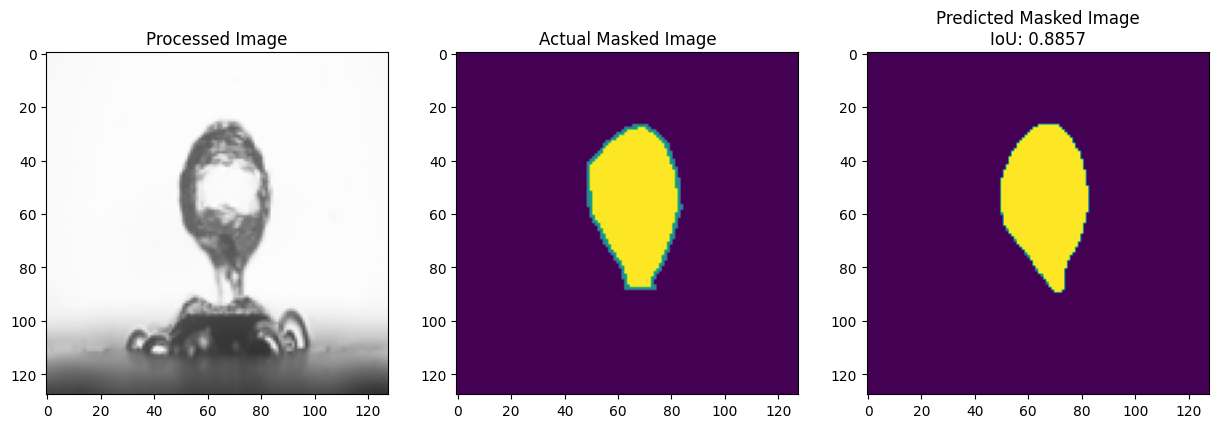

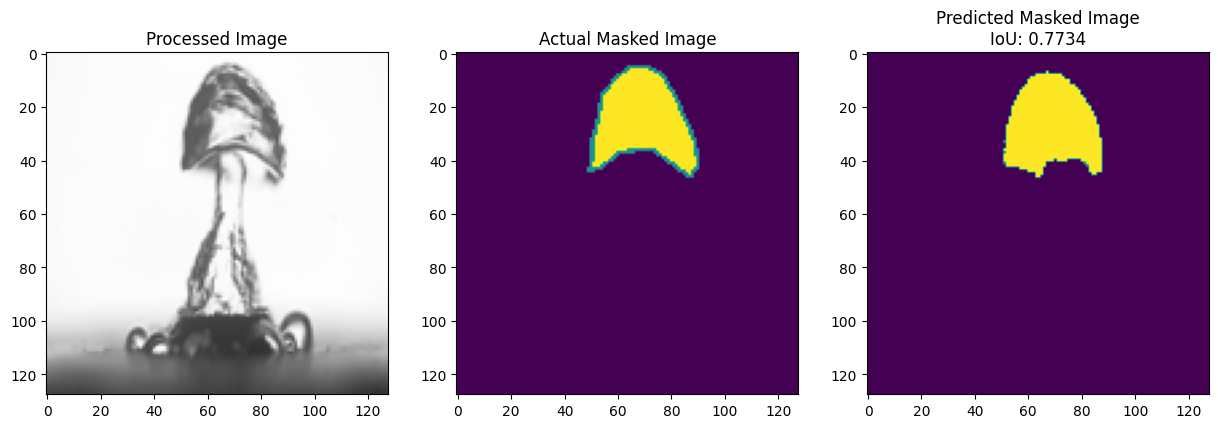

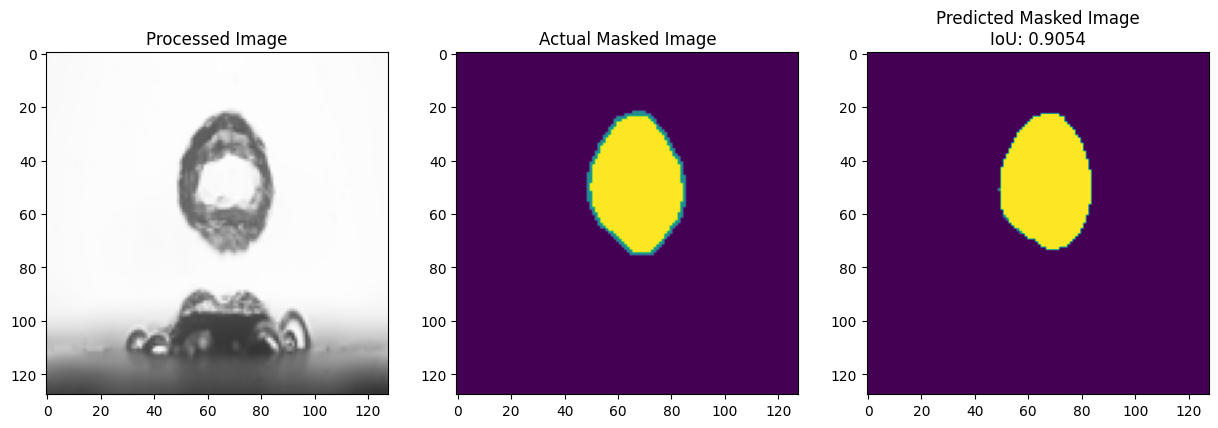

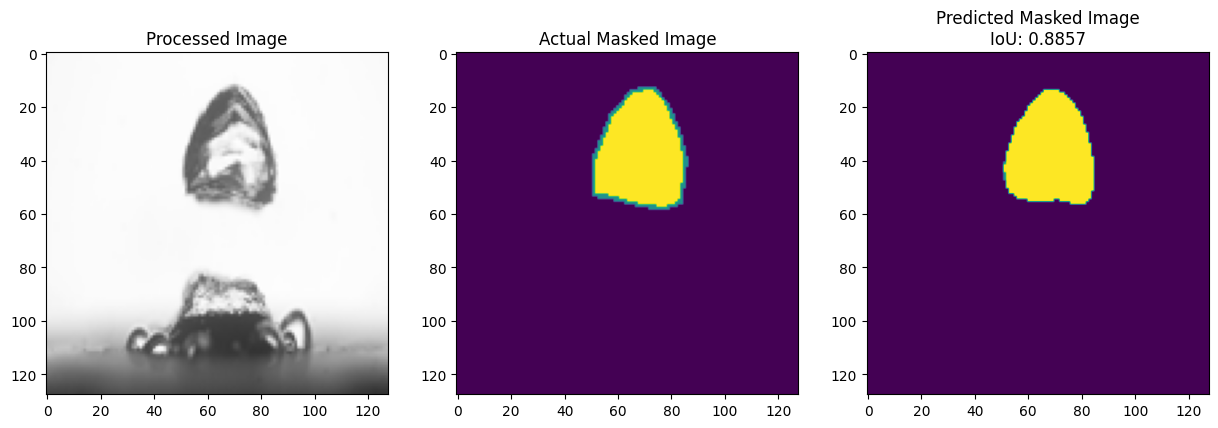

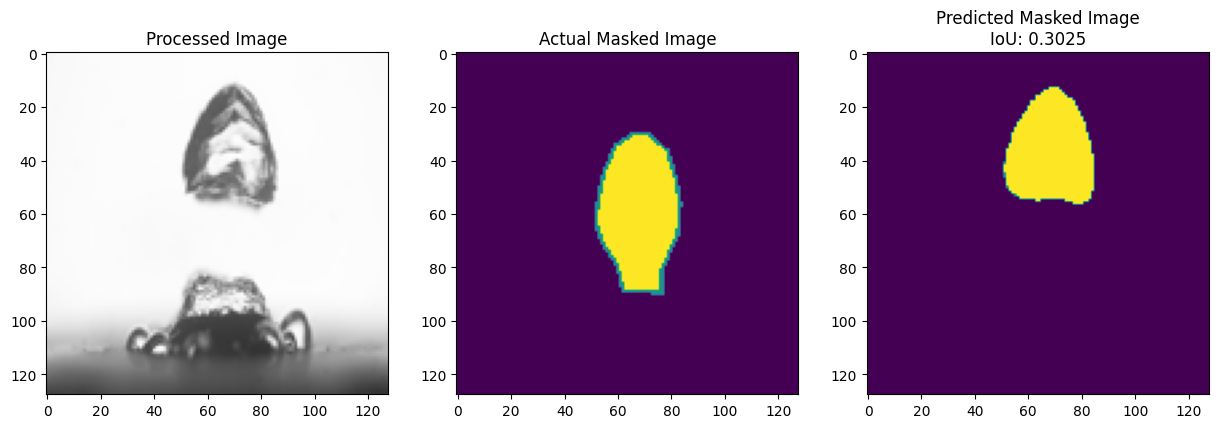

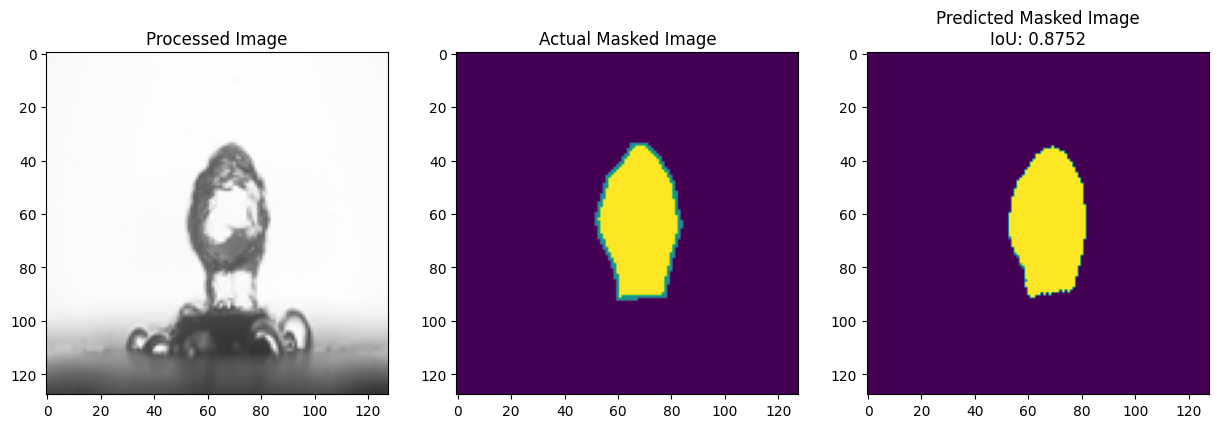

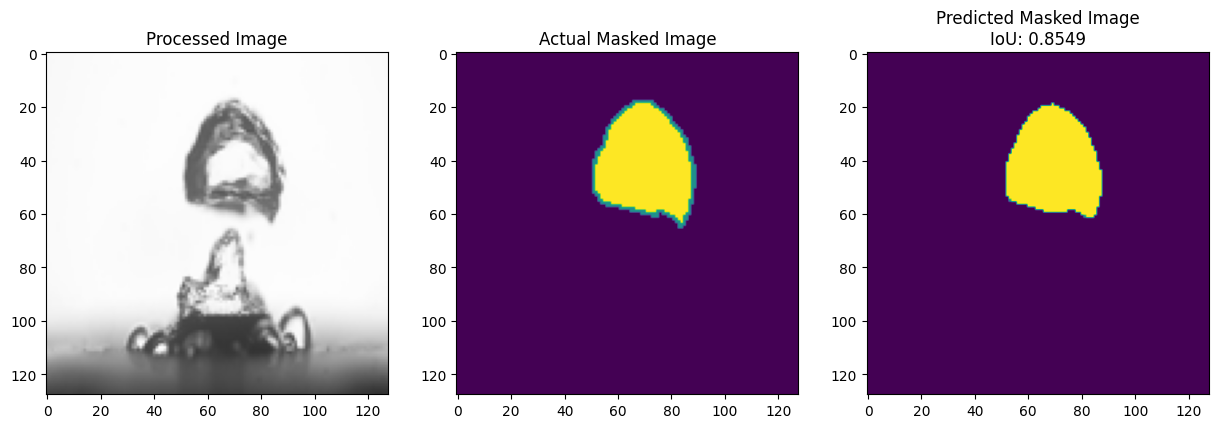

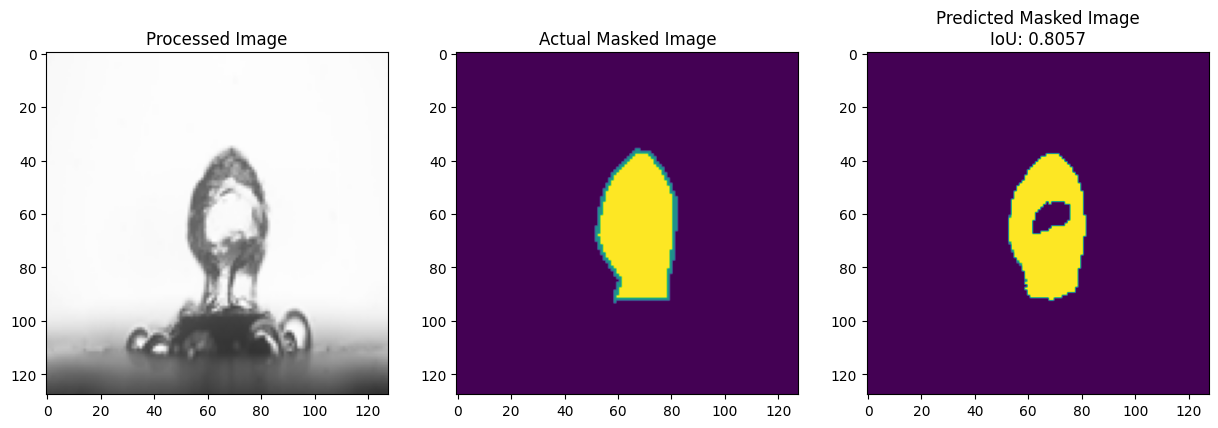

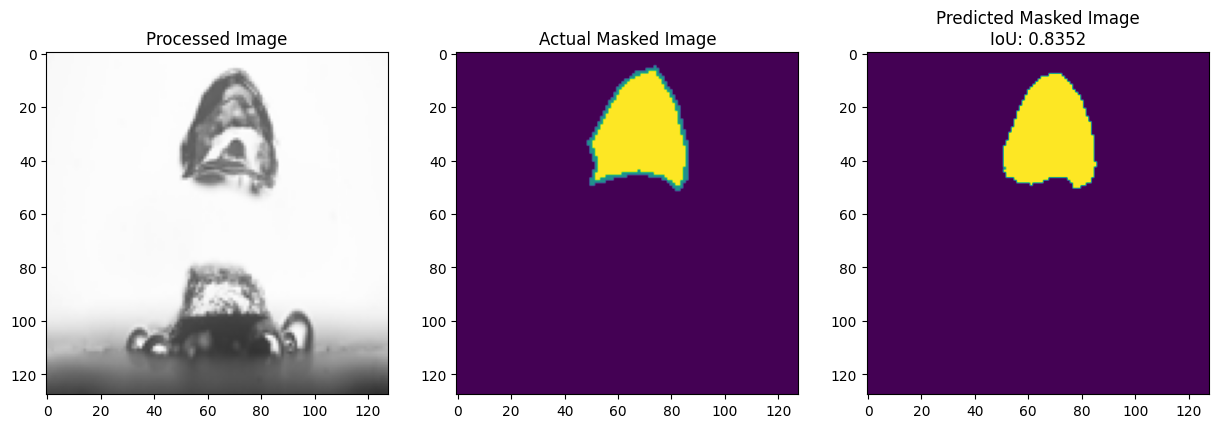

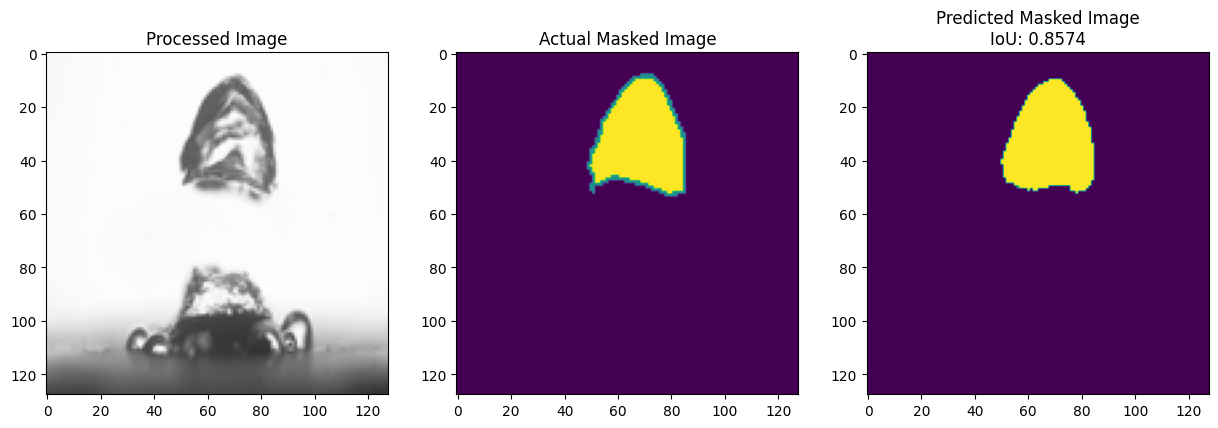

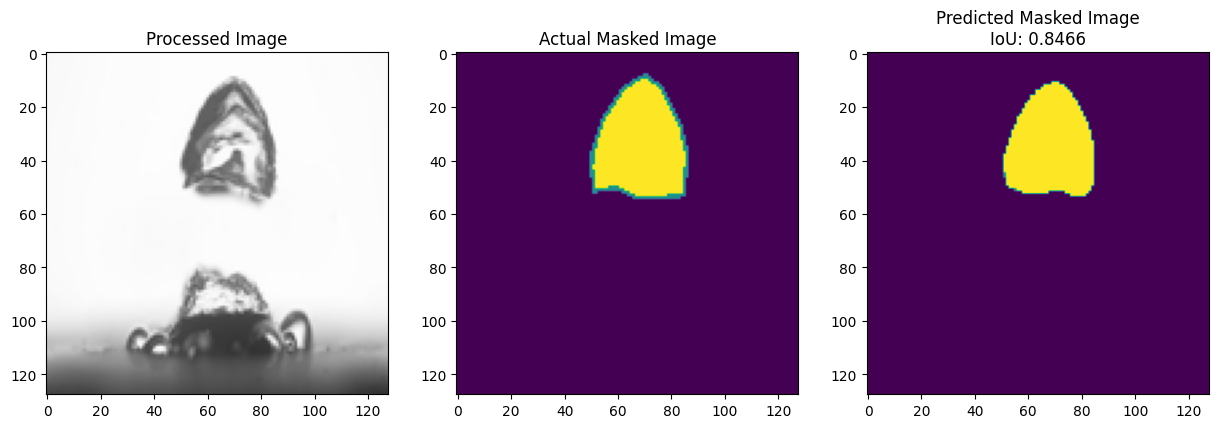

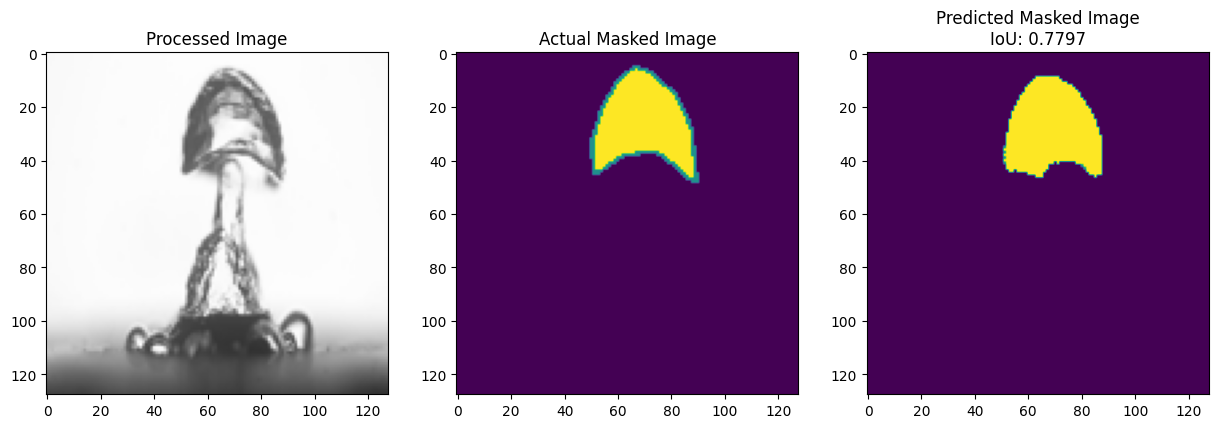

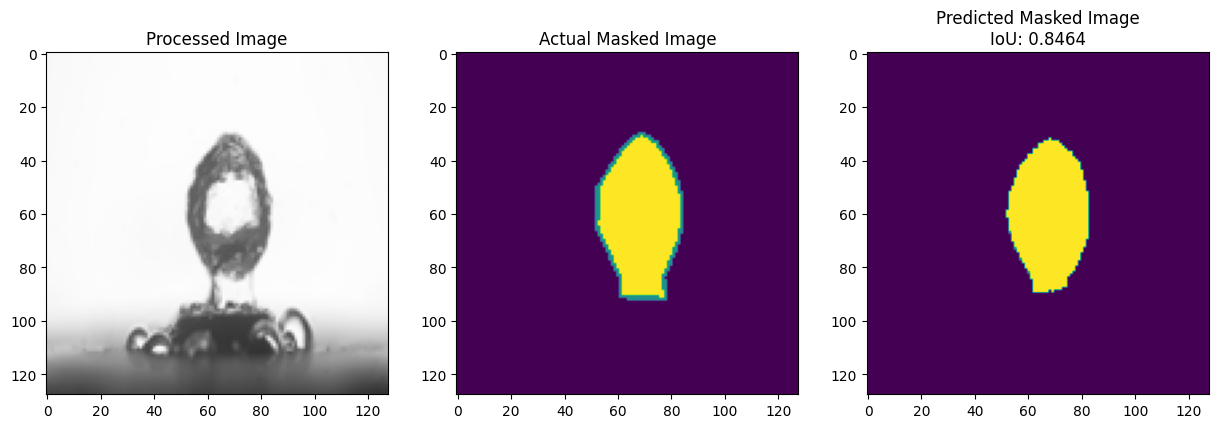

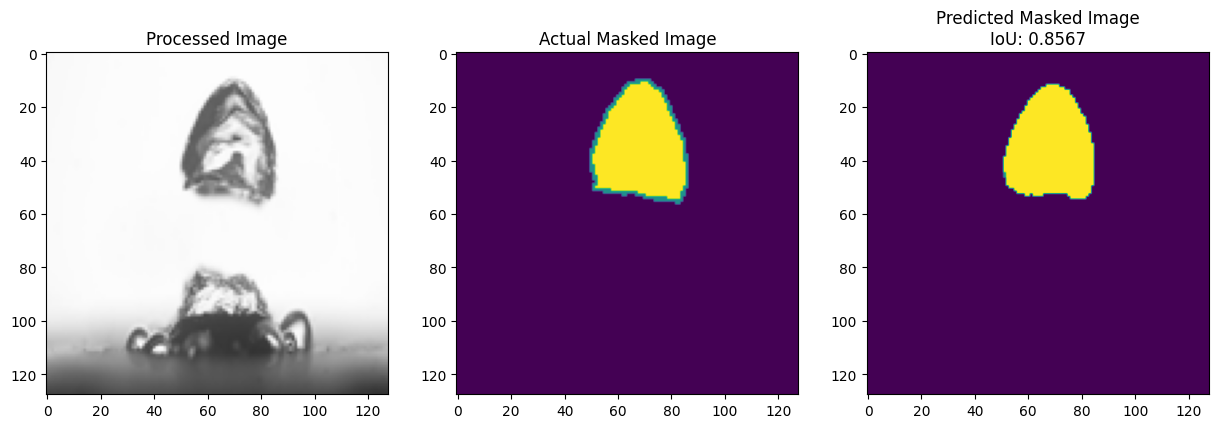

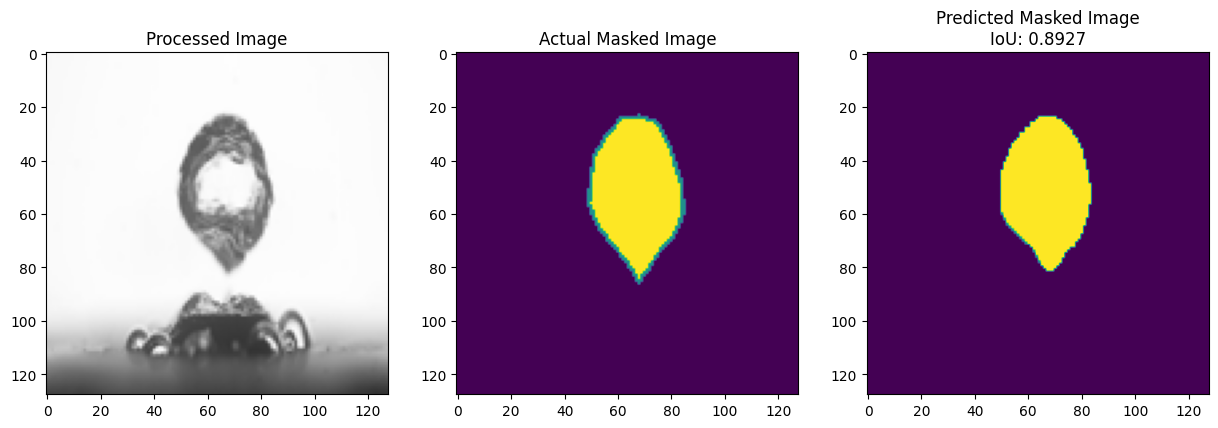

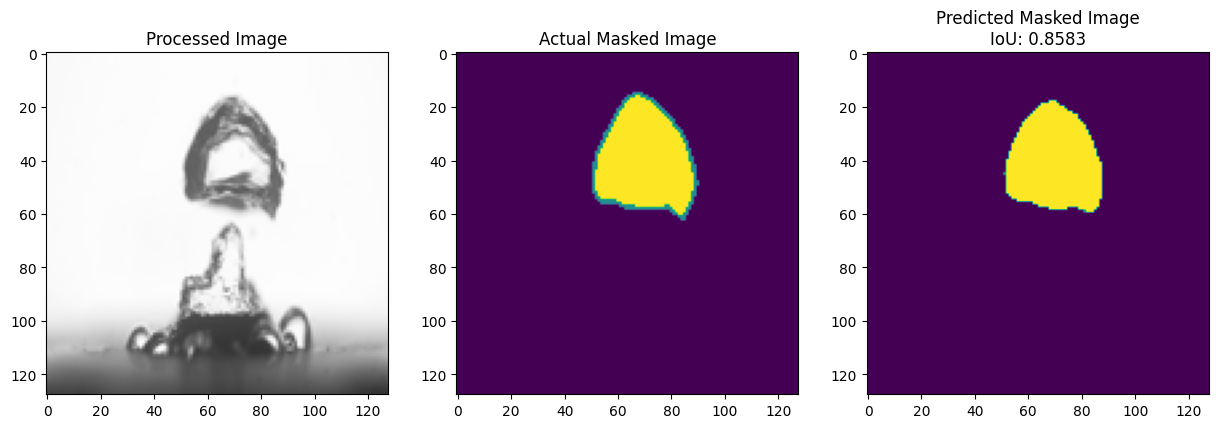

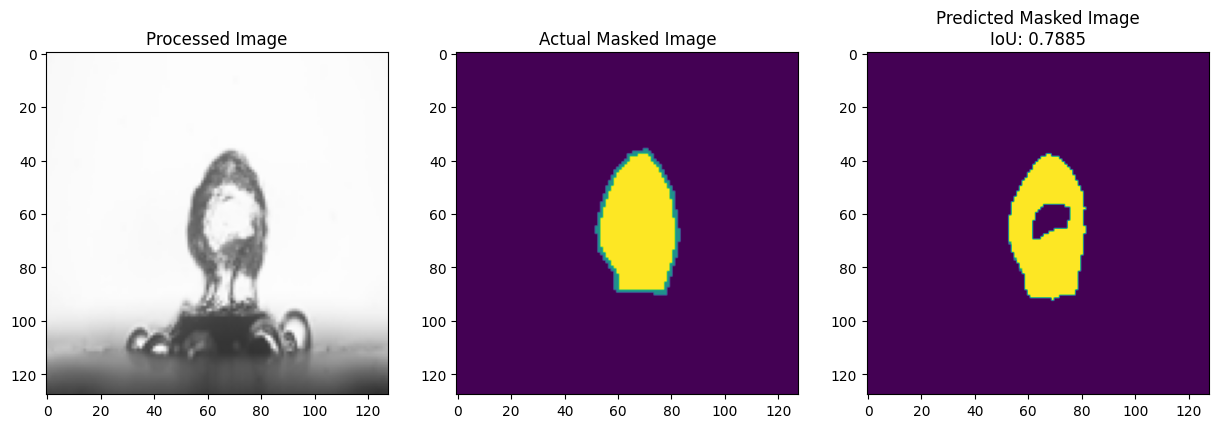

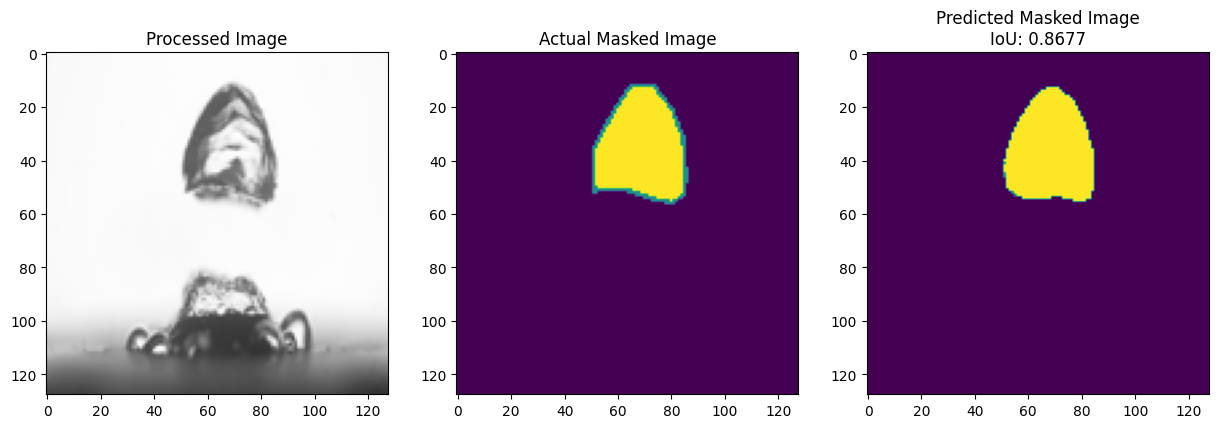

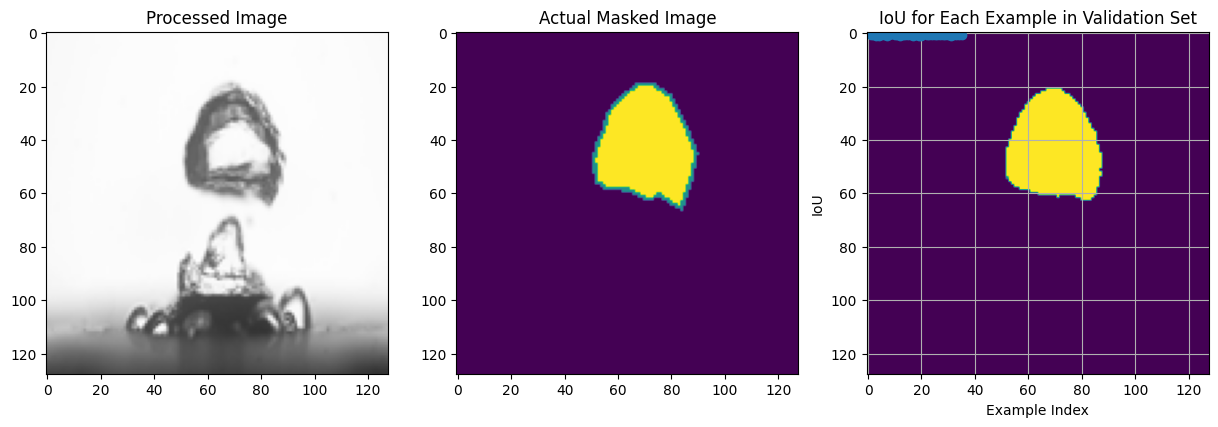

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define your calculate_iou function here

def visualize_results_and_get_iou(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]  # Add batch dimension for model prediction
    actual_mask = y_valid[index, :, :, 0]

    # Get model prediction
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Calculate IoU
    iou = calculate_iou(actual_mask, pred_mask[:, :, 0])

    # Visualize the results
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')

    arr[1].imshow(actual_mask)
    arr[1].set_title('Actual Masked Image')

    arr[2].imshow(pred_mask[:, :, 0])
    arr[2].set_title(f'Predicted Masked Image\nIoU: {iou:.4f}')

    return iou

# Calculate IoU for each example in the validation set
iou_values_per_example = [visualize_results_and_get_iou(index) for index in range(len(X_valid))]

# Plot the IoU values
examples = range(1, len(X_valid) + 1)
plt.plot(examples, iou_values_per_example, marker='o')
plt.xlabel('Example Index')
plt.ylabel('IoU')
plt.title('IoU for Each Example in Validation Set')
plt.grid(True)
plt.show()
